## Movielens

In [10]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *
from fastai.column_data import *

Data available from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

In [6]:
path='/Users/xbno/ML/fastai/data/ml-latest-small/'

We're working with the movielens data, which contains one rating per row, like this:

In [432]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Just for display purposes, let's read in the movie names too.

In [433]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Create genres thing

In [393]:
genres = movies['genres'].str.split('|')#,expand=True).head()

In [394]:
from collections import Counter

def flatten(l):
    for el in l:
        if isinstance(el, collections.Iterable) and not isinstance(el, (str, bytes)):
            yield from flatten(el)
        else:
            yield el

In [395]:
Counter(flatten(genres.tolist()))

Counter({'Adventure': 1263,
         'Animation': 611,
         'Children': 664,
         'Comedy': 3756,
         'Fantasy': 779,
         'Romance': 1596,
         'Drama': 4361,
         'Action': 1828,
         'Crime': 1199,
         'Thriller': 1894,
         'Horror': 978,
         'Mystery': 573,
         'Sci-Fi': 980,
         'War': 382,
         'Musical': 334,
         'Documentary': 440,
         'IMAX': 158,
         'Western': 167,
         'Film-Noir': 87,
         '(no genres listed)': 34})

In [396]:
from sklearn.feature_extraction.text import CountVectorizer

In [397]:
cv = CountVectorizer(token_pattern="(?u)\\b[\\w-]+\\b",ngram_range=(1,2),min_df=1500)

In [398]:
genres = cv.fit_transform(movies['genres'])

In [399]:
genres = pd.DataFrame(genres.todense())

In [427]:
genres['genreId'] = genres[0].astype(str)+genres[1].astype(str)+genres[2].astype(str)+genres[3].astype(str)+genres[4].astype(str)

In [426]:
genres.isnull().sum()

movieId    0
0          0
1          0
2          0
3          0
4          0
all        0
genreId    0
dtype: int64

In [402]:
cv.get_feature_names()

['action', 'comedy', 'drama', 'romance', 'thriller']

In [428]:
n_genres = genres['genreId'].nunique()

In [404]:
ratings.shape

(100836, 4)

In [405]:
genres = pd.concat([movies['movieId'],genres],axis=1)

In [429]:
genres['genreId'].value_counts()

01000    1777
00100    1766
00000    1117
01100     600
00101     540
10000     519
00110     514
00001     507
01010     499
10001     375
01110     331
11000     293
10100     263
10101     187
01001      77
00010      71
11001      54
00111      48
11100      31
11010      29
01101      27
00011      24
10110      21
10010      14
11101      13
10011      11
01011      10
10111       9
01111       6
11011       4
11110       3
11111       2
Name: genreId, dtype: int64

## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [408]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [47]:
ratings.groupby('movieId')['rating'].count().sort_values(ascending=False).head()

movieId
356     329
318     317
296     307
593     279
2571    278
Name: rating, dtype: int64

In [9]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15]

g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,50,110,260,296,318,356,480,527,589,593,1196,2571,2858,2959
userId,,,,,,,,,,,,,,,
68,2.5,3.0,2.5,5.0,2.0,3.0,3.5,3.5,4.0,3.5,3.5,5.0,4.5,5.0,2.5
182,4.0,4.5,3.5,3.5,5.0,4.5,5.0,3.5,4.0,2.0,4.5,3.0,5.0,5.0,5.0
249,4.0,4.0,5.0,5.0,4.0,4.5,4.5,4.0,4.5,4.0,4.0,5.0,5.0,4.5,5.0
274,4.0,4.0,4.5,3.0,5.0,4.5,4.5,3.5,4.0,4.5,4.0,4.5,4.0,5.0,5.0
288,4.5,NaN,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,5.0,4.5,3.0,NaN,3.5
307,4.0,4.5,3.5,3.5,4.5,4.5,4.0,3.5,4.5,2.5,4.5,3.0,3.5,4.0,4.0
380,5.0,4.0,4.0,5.0,5.0,3.0,5.0,5.0,NaN,5.0,5.0,5.0,4.5,NaN,4.0
387,NaN,4.5,3.5,4.5,5.0,3.5,4.0,3.0,NaN,3.5,4.0,4.5,4.0,4.5,4.5
414,4.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0


## Collaborative filtering

In [96]:
val_idxs = get_cv_idxs(len(ratings))
wd=2e-4
n_factors = 25

In [97]:
cf = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating')

In [99]:
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)

In [100]:
learn.fit(1e-2, 2, wds=wd, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                  
    0      0.756397   0.779486  
    1      0.723445   0.748435                                  
    2      0.606648   0.735373                                  


[array([0.73537])]

Let's compare to some benchmarks. Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on [RMSE](http://www.statisticshowto.com/rmse/) of 0.91. We'll need to take the square root of our loss, since we use plain MSE.

In [91]:
math.sqrt(0.7385)

0.8593602271457529

Looking good - we've found a solution better than any of those benchmarks! Let's take a look at how the predictions compare to actuals for this model.

In [92]:
learn.predict().shape

(20167,)

In [93]:
preds = learn.predict()

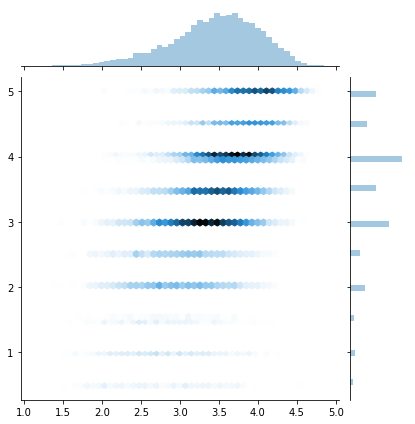

In [94]:
y=learn.data.val_y
sns.jointplot(preds, y, kind='hex', stat_func=None);

## Analyze results

### Movie bias

In [102]:
movie_names = movies.set_index('movieId')['title'].to_dict()
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False).index.values[:3000]
topMovieIdx = np.array([cf.item2idx[o] for o in topMovies])

In [103]:
m=learn.model#; m.cuda()

First, we'll look at the movie bias term. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [104]:
movie_bias = to_np(m.ib(V(topMovieIdx)))

In [105]:
movie_bias

array([[ 0.85911],
       [ 1.26752],
       [ 0.92324],
       ...,
       [-0.27967],
       [ 0.0959 ],
       [ 0.05555]], dtype=float32)

In [106]:
movie_ratings = [(b[0], movie_names[i]) for i,b in zip(topMovies,movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [107]:
sorted(movie_ratings, key=lambda o: o[0])[:15]

[(-0.7538563, 'Spice World (1997)'),
 (-0.73672694, 'Battlefield Earth (2000)'),
 (-0.69662356, 'Speed 2: Cruise Control (1997)'),
 (-0.66828376, 'Godzilla (1998)'),
 (-0.65842015, 'Jason X (2002)'),
 (-0.65822566, 'Flintstones in Viva Rock Vegas, The (2000)'),
 (-0.65340805, 'Catwoman (2004)'),
 (-0.64498407, 'Wild Wild West (1999)'),
 (-0.62670094, 'Honey, I Blew Up the Kid (1992)'),
 (-0.6248076, 'Karate Kid, Part III, The (1989)'),
 (-0.5996007, 'Problem Child (1990)'),
 (-0.5974781, 'Anaconda (1997)'),
 (-0.578285, 'Super Mario Bros. (1993)'),
 (-0.57720363, 'Stop! Or My Mom Will Shoot (1992)'),
 (-0.56628716, 'Stuart Saves His Family (1995)')]

In [109]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(1.2675233, 'Shawshank Redemption, The (1994)'),
 (0.9232441, 'Pulp Fiction (1994)'),
 (0.89680755,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'),
 (0.8934899, 'Usual Suspects, The (1995)'),
 (0.86886156, 'Fight Club (1999)'),
 (0.8591137, 'Forrest Gump (1994)'),
 (0.857092, 'Goodfellas (1990)'),
 (0.8547608, "Schindler's List (1993)"),
 (0.8520674, 'Star Wars: Episode IV - A New Hope (1977)'),
 (0.84840876, "Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)"),
 (0.83920974, 'Princess Bride, The (1987)'),
 (0.82542, 'American History X (1998)'),
 (0.82382417, 'Casablanca (1942)'),
 (0.82357174, 'Godfather, The (1972)'),
 (0.823, 'Star Wars: Episode V - The Empire Strikes Back (1980)')]

### Embedding interpretation

We can now do the same thing for the embeddings.

In [110]:
movie_emb = to_np(m.i(V(topMovieIdx)))
movie_emb.shape

(3000, 25)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [27]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [28]:
movie_pca.shape

(3, 3000)

In [29]:
fac0 = movie_pca[0]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'easy watching' vs 'serious'.

In [30]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.06557032, 'Twister (1996)'),
 (0.057259742, 'Broken Arrow (1996)'),
 (0.055802546, 'Demolition Man (1993)'),
 (0.05385411, 'Santa Clause, The (1994)'),
 (0.053636685, 'Mummy, The (1999)'),
 (0.05234498, 'Lara Croft: Tomb Raider (2001)'),
 (0.052334886, 'Coyote Ugly (2000)'),
 (0.052291006, 'Client, The (1994)'),
 (0.051639263, 'First Knight (1995)'),
 (0.050986107, 'Home Alone 2: Lost in New York (1992)')]

In [31]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.084740415, 'Pulp Fiction (1994)'),
 (-0.08428396, 'Requiem for a Dream (2000)'),
 (-0.082625724, 'Godfather, The (1972)'),
 (-0.07638154, 'Memento (2000)'),
 (-0.07390876, 'Monty Python and the Holy Grail (1975)'),
 (-0.07115708, "Schindler's List (1993)"),
 (-0.06777379, 'Godfather: Part II, The (1974)'),
 (-0.06375171, 'Fight Club (1999)'),
 (-0.06268987, 'Big Lebowski, The (1998)'),
 (-0.06190123, 'American Beauty (1999)')]

In [32]:
fac1 = movie_pca[1]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac1, topMovies)]

Here's the 2nd component. It seems to be 'CGI' vs 'dialog driven'.

In [33]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.1091889, 'Back to the Future (1985)'),
 (0.10244019, 'Matrix, The (1999)'),
 (0.088507384,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'),
 (0.08271536, 'Speed (1994)'),
 (0.08086369, 'Star Wars: Episode IV - A New Hope (1977)'),
 (0.08044679, 'Star Wars: Episode I - The Phantom Menace (1999)'),
 (0.080277495, 'Braveheart (1995)'),
 (0.08021546, 'Jurassic Park (1993)'),
 (0.07862022, 'Saving Private Ryan (1998)'),
 (0.07783831, 'Armageddon (1998)')]

In [34]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.05929031, 'Blair Witch Project, The (1999)'),
 (-0.052741013, 'Judge Dredd (1995)'),
 (-0.051340576, 'Battlefield Earth (2000)'),
 (-0.04879656, 'Election (1999)'),
 (-0.047805022, 'Predator 2 (1990)'),
 (-0.04763737, 'Mulholland Drive (2001)'),
 (-0.045170266, 'Crying Game, The (1992)'),
 (-0.04382374, 'Blood Simple (1984)'),
 (-0.043169674, 'Deer Hunter, The (1978)'),
 (-0.041674867, 'Mystery Men (1999)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the first two components.

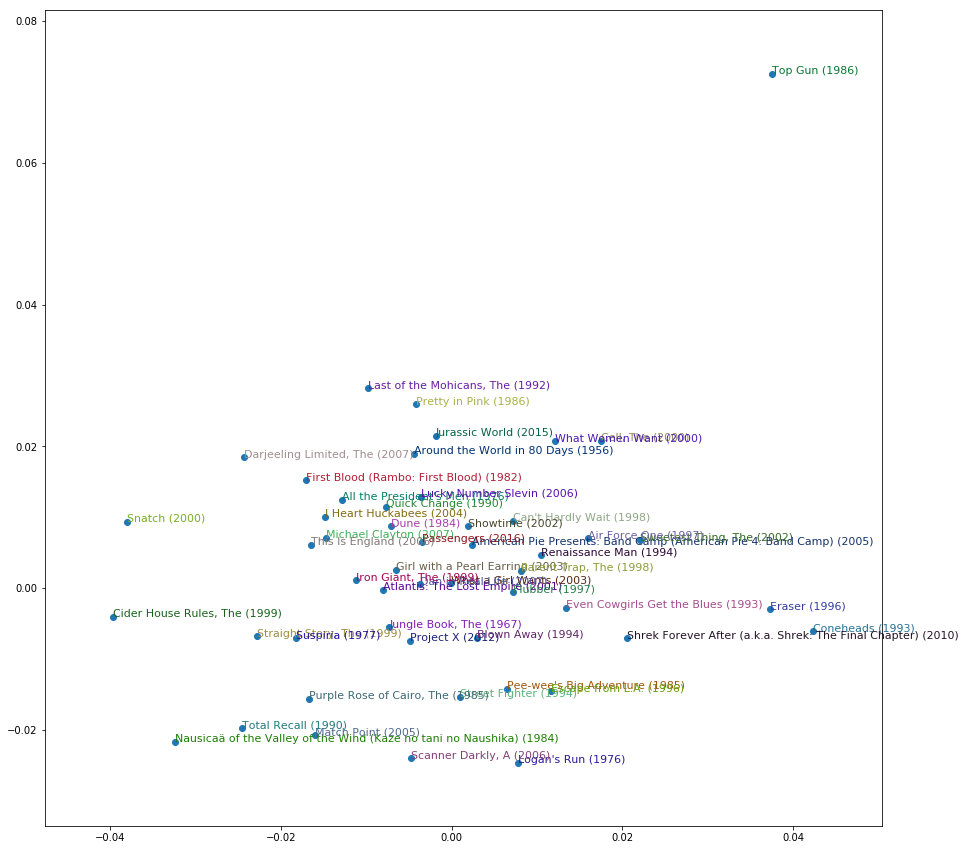

In [35]:
idxs = np.random.choice(len(topMovies), 50, replace=False)
X = fac0[idxs]
Y = fac1[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[idxs], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

## Collab filtering from scratch

### Dot product example

In [36]:
a = T([[1.,2],[3,4]])
b = T([[2.,2],[10,10]])
a,b

(
  1  2
  3  4
 [torch.FloatTensor of size 2x2], 
   2   2
  10  10
 [torch.FloatTensor of size 2x2])

In [112]:
a*b


  2   4
 30  40
[torch.FloatTensor of size 2x2]

In [113]:
(a*b).sum(1)


  6
 70
[torch.FloatTensor of size 2]

In [114]:
class DotProduct(nn.Module):
    def forward(self, u, m): return (u*m).sum(1)

In [115]:
model=DotProduct()

In [116]:
model(a,b)


  6
 70
[torch.FloatTensor of size 2]

### Dot product model

In [117]:
u_uniq = ratings.userId.unique()
user2idx = {o:i for i,o in enumerate(u_uniq)}
ratings.userId = ratings.userId.apply(lambda x: user2idx[x])

m_uniq = ratings.movieId.unique()
movie2idx = {o:i for i,o in enumerate(m_uniq)}
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])

n_users=int(ratings.userId.nunique())
n_movies=int(ratings.movieId.nunique())

In [122]:
class EmbeddingDot(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.u.weight.data.uniform_(0,0.05)
        self.m.weight.data.uniform_(0,0.05)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        u,m = self.u(users),self.m(movies)
        return (u*m).sum(1).view(-1, 1)

In [523]:
genres.columns#.head()#[['modelId','genreId']].head()

Index(['movieId', 0, 1, 2, 3, 4, 'all', 'genreId'], dtype='object')

In [529]:
ratings = ratings.join(genres[['movieId','genreId']],rsuffix='r')

In [525]:
ratings.drop('genreId',axis=1,inplace=True)

In [435]:
ratings.drop('movieIdr',axis=1,inplace=True)

In [530]:
ratings['genreId'] = ratings['genreId'].fillna('99999')

In [538]:
ratings['genreId'] = pd.Categorical(ratings['genreId'])

In [447]:
ratings['genreId'] = pd.Categorical(ratings['genreId'].astype(str).str.replace('z','99999'))

In [539]:
ratings['genreId'] = ratings['genreId'].cat.codes.astype(np.int64)

In [448]:
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
genreId      0
dtype: int64

In [540]:
x = ratings.drop(['rating', 'timestamp'],axis=1)
y = ratings['rating'].astype(np.float32)

In [480]:
data = ColumnarModelData.from_data_frame(path, val_idxs, x, y, ['userId', 'movieId'], 64)

In [541]:
ratings.head()

,userId,movieId,rating,timestamp,movieIdr,genreId
0,1,1,4.0,964982703,1.0,8
1,1,3,4.0,964981247,2.0,0
2,1,6,4.0,964982224,3.0,10
3,1,47,5.0,964983815,4.0,14
4,1,50,5.0,964982931,5.0,8


In [542]:
data = ColumnarModelData.from_data_frame(path, val_idxs, x, y, ['userId', 'movieId', 'genreId'], 64)

In [543]:
x.dtypes

userId        int64
movieId       int64
movieIdr    float64
genreId       int64
dtype: object

In [544]:
wd=1e-5
model = EmbeddingDot(n_users, n_movies)#.cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

In [545]:
fit(model, data, 3, opt, F.mse_loss)

  0%|          | 0/1261 [00:00<?, ?it/s]

RuntimeError: index out of range at /Users/soumith/minicondabuild3/conda-bld/pytorch_1518385717421/work/torch/lib/TH/generic/THTensorMath.c:277

In [126]:
set_lrs(opt, 0.01)

In [127]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss                                  
    0      0.695387   1.197965  
    1      0.693555   1.184376                                  
    2      0.663732   1.177501                                  


[array([1.1775])]

### Bias

In [128]:
min_rating,max_rating = ratings.rating.min(),ratings.rating.max()
min_rating,max_rating

(0.5, 5.0)

In [129]:
def get_emb(ni,nf):
    e = nn.Embedding(ni, nf)
    e.weight.data.uniform_(-0.01,0.01)
    return e

class EmbeddingDotBias(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        (self.u, self.m, self.ub, self.mb) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors), (n_users,1), (n_movies,1)
        ]]
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        um = (self.u(users)* self.m(movies)).sum(1)
        res = um + self.ub(users).squeeze() + self.mb(movies).squeeze()
        res = F.sigmoid(res) * (max_rating-min_rating) + min_rating
        return res.view(-1, 1)

In [131]:
wd=2e-4
model = EmbeddingDotBias(cf.n_users, cf.n_items)#.cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

In [132]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss                                  
    0      0.7886     0.813292  
    1      0.75536    0.79222                                   
    2      0.760704   0.78842                                   


[array([0.78842])]

In [133]:
set_lrs(opt, 1e-2)

In [134]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss                                  
    0      0.7168     0.781315  
    1      0.721354   0.780008                                  
    2      0.709112   0.78008                                   


[array([0.78008])]

### Mini net

In [145]:
get_emb(*(10,10))

Embedding(10, 10)

In [146]:
get_emb(10,10)

Embedding(10, 10)

In [139]:
[get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors)]]

[Embedding(610, 25), Embedding(9724, 25)]

In [ ]:
# class EmbeddingNet(nn.Module):
#     def __init__(self, n_users, n_movies, user_factors=10, movie_factors=5 ,nh=20, nh2=10, p1=0.05, p2=0.5):
#         super().__init__()
#         (self.u, self.m) = [get_emb(*o) for o in [
#             (n_users, user_factors), (n_movies, movie_factors)]]
#         self.lin1 = nn.Linear(user_factors+movie_factors, nh)
#         self.lin2 = nn.Linear(nh, 1)
#         self.drop1 = nn.Dropout(p1)
#         self.drop2 = nn.Dropout(p2)
        
#     def forward(self, cats, conts):
#         users,movies = cats[:,0],cats[:,1]
#         x = self.drop1(torch.cat([self.u(users),self.m(movies)], dim=1))
#         x = self.drop2(F.relu(self.lin1(x)))
#         return F.sigmoid(self.lin2(x)) * (max_rating-min_rating+1) + min_rating-0.5

In [547]:
class EmbeddingNet(nn.Module):
    def __init__(self, n_users, n_movies, n_genres, user_factors=10, movie_factors=5, genre_factors=10, nh=20, nh2=10, p1=0.05, p2=0.5):
        super().__init__()
        (self.u, self.m, self.g) = [get_emb(*o) for o in [
            (n_users, user_factors), (n_movies, movie_factors), (n_genres, genre_factors)]]
        self.lin1 = nn.Linear(user_factors+movie_factors+genre_factors, nh)
        self.lin2 = nn.Linear(nh, 1)
        self.drop1 = nn.Dropout(p1)
        self.drop2 = nn.Dropout(p2)
        
    def forward(self, cats, conts):
        users,movies,genres = cats[:,0],cats[:,1],cats[:,2]
        x = self.drop1(torch.cat([self.u(users),self.m(movies),self.g(genres)], dim=1))
        x = self.drop2(F.relu(self.lin1(x)))
        return F.sigmoid(self.lin2(x)) * (max_rating-min_rating+1) + min_rating-0.5

In [546]:
#x['genreId'].value_counts()

In [548]:
wd=1e-5
model = EmbeddingNet(n_users, n_movies, n_genres)#.cuda()
opt = optim.Adam(model.parameters(), 1e-3, weight_decay=wd)

In [549]:
model.parameters

<bound method Module.parameters of EmbeddingNet(
  (u): Embedding(610, 10)
  (m): Embedding(9724, 5)
  (g): Embedding(33, 10)
  (lin1): Linear(in_features=25, out_features=20, bias=True)
  (lin2): Linear(in_features=20, out_features=1, bias=True)
  (drop1): Dropout(p=0.05)
  (drop2): Dropout(p=0.5)
)>

In [550]:
fit(model, data, 3, opt, F.mse_loss)

  0%|          | 0/1261 [00:00<?, ?it/s]

RuntimeError: index out of range at /Users/soumith/minicondabuild3/conda-bld/pytorch_1518385717421/work/torch/lib/TH/generic/THTensorMath.c:277

In [506]:
model.g.weight[32,:]

Variable containing:
1.00000e-03 *
 -9.9662
  3.6752
 -1.4194
  9.0159
 -8.1776
  6.8769
  2.3055
 -1.8697
  6.8475
  9.9471
[torch.FloatTensor of size 10]

In [157]:
set_lrs(opt, 1e-3)

In [158]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss                                  
    0      0.704013   0.764167  
    1      0.729303   0.762045                                  
    2      0.68809    0.76494                                   


[array([0.76494])]